In [362]:
# Training Energy-based Models
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

In [601]:
def pinwheel_data(n=10000, radial_std=.3, tangential_std=.05, num_classes=5, rate=0.25, norm_data=None):
    num_per_class = int(n/num_classes)
    assert n%num_classes == 0
    rads = np.linspace(0, 2*np.pi, num_classes, endpoint=False)
    features = np.random.randn(num_classes*num_per_class, 2) * np.array([radial_std, tangential_std])
    features[:,0]+=1
    labels = np.repeat(np.arange(num_classes), num_per_class)
    
    angles = rads[labels] + rate * np.exp(features[:,0])
    rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = np.reshape(rotations.T, (-1,2,2))
    
    data = np.random.permutation(np.einsum('ti,tij->tj', features, rotations))
    
    # normalize data to -1, 1
    if norm_data is None:
        minx, maxx, miny, maxy = np.min(data[:,0]), np.max(data[:,0]), np.min(data[:,1]), np.max(data[:,1])
        norm_data = {'minx': minx, 'maxx': maxx, 'miny':miny, 'maxy': maxy}
    else:
        minx, maxx, miny, maxy = norm_data['minx'], norm_data['maxx'], norm_data['miny'], norm_data['maxy']
    data[:,0] = (data[:,0]-minx)/ (maxx-minx)
    data[:,1] = (data[:,1]-miny)/ (maxy-miny)
    data = 2*data - 1.0
    return data, norm_data

def flower_data(batch_size):
    z_true = np.random.uniform(0,1,batch_size)
    r = np.power(z_true, 0.5)
    phi = 0.25 * np.pi * z_true
    x1 = r*np.cos(phi)
    x2 = r*np.sin(phi)
    
    # Sampling form a Gaussian
    x1 = np.random.normal(x1, 0.10* np.power(z_true,2), batch_size)
    x2 = np.random.normal(x2, 0.10* np.power(z_true,2), batch_size)
        
    # Bringing data in the right form
    X = np.transpose(np.reshape((x1,x2), (2, batch_size)))
    data = np.asarray(X, dtype='float32')
    # normalize data to -1, 1
    minx, maxx, miny, maxy = np.min(data[:,0]), np.max(data[:,0]), np.min(data[:,1]), np.max(data[:,1])
    data[:,0] = (data[:,0]-minx)/ (maxx-minx)
    data[:,1] = (data[:,1]-miny)/ (maxy-miny)
    data = 2*data - 1.0
    return data

def norm_data(batch_size):
    data = np.random.randn(batch_size, 2)
    minx, maxx, miny, maxy = np.min(data[:,0]), np.max(data[:,0]), np.min(data[:,1]), np.max(data[:,1])
    data[:,0] = (data[:,0]-minx)/ (maxx-minx)
    data[:,1] = (data[:,1]-miny)/ (maxy-miny)
    data = 2*data - 1.0
    return data


-1.0 1.0 -1.0 1.0


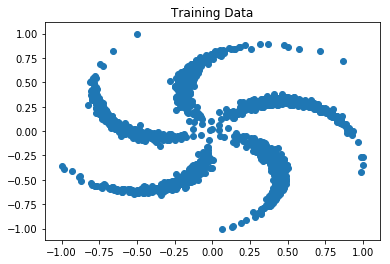

In [602]:
X, norm_data = pinwheel_data(2000, num_classes=5) #pinwheel_data(999, num_classes=3)
#X = norm_data(4000)
print(np.min(X[:,0]), np.max(X[:,0]), np.min(X[:,1]), np.max(X[:,1]))
plt.title('Training Data')
plt.scatter(X[:,0], X[:,1])
plt.show()

def get_dense_grid(X, resolution=50):
    dense_grid_x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), num=resolution)
    dense_grid_y = np.linspace(np.min(X[:,1]), np.max(X[:,1]), num=resolution)
    gridpoints = np.zeros((resolution**2, 2))
    for i in range(resolution):
        for j in range(resolution):
            gridpoints[i*resolution+j] = [dense_grid_x[i], dense_grid_y[j]]
    return gridpoints

def plot_gridpoints(grid_vals):
    res2 = grid_vals.shape
    resolution = int(np.sqrt(res2))
    gridpoints = np.reshape(grid_vals, [resolution, resolution])
    plt.imshow(np.flipud(gridpoints.T), cmap='afmhot', extent=[-1,1,-1,1])

In [482]:
def svgd_kernel(theta, h = -1):
    sq_dist = pdist(theta)
    pairwise_dists = squareform(sq_dist)**2
    if h < 0: # if h < 0, using median trick
        scale = np.abs(h)
        h = np.median(pairwise_dists)  
        h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1)) * scale

    # compute the rbf kernel
    Kxy = np.exp( -pairwise_dists / h**2 / 2)

    dxkxy = -np.matmul(Kxy, theta)
    sumkxy = np.sum(Kxy, axis=1)
    for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
    dxkxy = dxkxy / (h**2)
    return (Kxy, dxkxy)


In [754]:
def linear(X, dout, name, bias=True):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        tf.add_to_collection('WEIGHT_DECAY', W)
        b = tf.get_variable('b', shape=(dout))
    if bias:
        return tf.matmul(X, W)+b
    else:
        return tf.matmul(X, W)

def energy_model(x, layers=[5], nonlin=tf.nn.elu, name='energy_net'):
    with tf.variable_scope(name):
        out = x
        for i, lsize in enumerate(layers):
            if i == len(layers)-1:
                nonlin = tf.tanh
            out = nonlin(linear(out, lsize, 'l%d'%i, bias=True))
        out = linear(out, 1, 'lfinal', bias=False)
    return out


def generator_arch(x, dout, phase, layers=[10], nonlin=tf.nn.relu, name='generator'):
    with tf.variable_scope(name):
        out = x
        for i, lsize in enumerate(layers):
            out = nonlin(linear(out, lsize, 'l%d'%i))
            #out = tf.contrib.layers.batch_norm(out, center=True, scale=True, is_training=phase, scope='bn%d'%i)
            #with tf.variable_scope('bn%d'%i, reuse=True):
            #    gamma = tf.get_variable('gamma')
            #tf.add_to_collection('BN_GAMMA', gamma)
            
        out = linear(out, dout, 'lfinal')
    return out


class Energy(object):
    def __init__(self, dX, magnitude_penalty_wt=1.0):
        self.dX = dX
        
        with tf.variable_scope('ebm') as vs:
            self.pos = tf.placeholder(tf.float32, [None, self.dX], name='pos')
            self.neg = tf.placeholder(tf.float32, [None, self.dX], name='neg')

            pos_energy = self.ebm_forward(self.pos, training=False, reuse=False)
            self.energy = self.ebm_forward(self.pos, training=False, reuse=True)
            self.energy_grad = tf.gradients(tf.reduce_sum(self.energy), self.pos)
            neg_energy = self.ebm_forward(self.neg, training=False, reuse=True)

            ebm_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=vs.name)

            grad_ebm_pos = tf.gradients(tf.reduce_sum(pos_energy), self.pos)[0]
            grad_ebm_neg = tf.gradients(tf.reduce_sum(neg_energy), self.neg)[0]
            grad_penalty = tf.reduce_sum(grad_ebm_pos*grad_ebm_pos)+tf.reduce_sum(grad_ebm_neg*grad_ebm_neg)

            wd_vars = tf.get_collection('WEIGHT_DECAY', scope=vs.name)
            #print('wd_vars', len(wd_vars)
            reg = 1e-4*tf.reduce_sum([tf.reduce_sum(w*w) for w in wd_vars])
            #reg = 1e-5 * grad_penalty
            #reg = 0
            
            magnitude_pen = tf.reduce_mean(tf.square(pos_energy))+tf.reduce_mean(tf.square(neg_energy))
            reg += magnitude_penalty_wt*magnitude_pen
            
            self.loss = tf.reduce_mean(pos_energy) - tf.reduce_mean(neg_energy) + reg
            self.step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.loss, var_list=ebm_vars)
            
    def update(self, positives, negatives):
        loss, _ = tf.get_default_session().run( [self.loss, self.step], 
                            feed_dict={self.pos:positives, self.neg:negatives})
        return loss

    def ebm_forward(self, input, training=False, reuse=True):
        with tf.variable_scope('energy_net', reuse=reuse):
            nrg = energy_model(input, layers=[64,64,32])
        return nrg
    
    def eval(self, points):
        return tf.get_default_session().run( self.energy, feed_dict={self.pos: points})[:,0]
    
    def eval_gradient(self, points):
        return tf.get_default_session().run( self.energy_grad, feed_dict={self.pos: points})[0]

class Generator(object):
    def __init__(self, dX, dNoise, ebm, name='generator'):
        self.dX =dX
        self.dNoise = dNoise
        self.ebm = ebm
        
        with tf.variable_scope(name) as vs:
            self.noise = tf.placeholder(tf.float32, [None, dNoise], name='noise')
            self.train = tf.placeholder(tf.bool, (), name='phase')
            self.samples = (generator_arch(self.noise, phase=self.train, dout=self.dX, layers=[50,10]))
            gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=vs.name)
            gammas = tf.get_collection('BN_GAMMA', scope=vs.name)
            
            
        with tf.variable_scope('ebm'):
            energies = (self.ebm.ebm_forward(self.samples))
            self.energies = energies
        
        # pairwise dists
        #A = self.samples
        #r = tf.reduce_sum(A*A, 1)
        # turn r into column vector
        #r = tf.reshape(r, [-1, 1])
        #D = r - 2*tf.matmul(A, tf.transpose(A)) + tf.transpose(r)
        #sum_dists = tf.reduce_mean(tf.exp(-D))
        
        with tf.variable_scope(name) as vs:
            entropy = 0
            for gamma in gammas:
                entropy += tf.reduce_sum(tf.log(2*np.pi*np.e*tf.square(gamma)+1e-8 )/2)
            self.loss = tf.reduce_mean(energies) - 0.1*entropy
            self.step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(self.loss, var_list=gen_vars) 
            
            self.vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=vs.name)

            
    def update(self, N=32):
        noise = np.random.randn(N, self.dNoise)
        loss, _ = tf.get_default_session().run( [self.loss, self.step], 
                                         feed_dict={self.noise: noise, self.train:True})
        return loss
    
    def generate(self, N=32):
        noise = np.random.randn(N, self.dNoise)
        return tf.get_default_session().run( [self.samples, self.energies], feed_dict={self.noise: noise,
                                                                                      self.train: False})


class SVGDGenerator(object):
    def __init__(self, dX, dNoise, ebm, name='generator', use_tf=True):
        self.dX =dX
        self.dNoise = dNoise
        self.ebm = ebm
        
        if use_tf:
            with tf.variable_scope(name) as vs:
                self.noise = tf.placeholder(tf.float32, [None, dNoise], name='noise')
                self.target = tf.placeholder(tf.float32, [None, dX], name='target')
                self.svg = tf.placeholder(tf.float32, [None, dX], name='svg_directions')
                self.lr = tf.placeholder(tf.float32, (), name='lr')
                self.samples = tf.tanh(generator_arch(self.noise, phase=False, dout=self.dX, layers=[64,64]))
                gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=vs.name)

                #self.loss = tf.reduce_mean(tf.square(self.samples - (self.target)))
                self.loss = tf.reduce_mean(-self.samples * self.svg)
                self.step = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss, var_list=gen_vars) 
                self.vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=vs.name)


    def update(self, N=32, lr=1e-2, h=-1, clip=100.0, kernel_hack_scale=0.17, verbose=False):
        noise = np.random.randn(N, self.dNoise)
        samples = self.generate(noise=noise)
        
        # Compute stein var. gradient directions
        dprob = -self.ebm.eval_gradient(samples)
        if clip is not None:
            dprob = np.clip(dprob, -clip , clip)
        kernel_pairs, grad_kernel_pairs = svgd_kernel(samples, h=h)
        g = np.matmul(kernel_pairs, dprob) + kernel_hack_scale*grad_kernel_pairs
        g = g/float(N)
        #if clip is not None:
        #    g = np.clip(g, -clip , clip)
        if verbose:
            print('AverageGradient:', np.mean(np.linalg.norm(dprob, axis=1)))
        
        loss, _ = tf.get_default_session().run( [self.loss, self.step], 
                                         feed_dict={self.noise: noise, 
                                                    self.lr: lr, 
                                                    self.target: (samples+lr*g),
                                                    self.svg: g})
        return loss
    
    def svgd(self, particles=None, itrs=100, alpha=0.01, h=-1, clip=1):
        if particles is None:
            particles = np.random.randn(N, self.dNoise)
        # perform SVGD
        for itr in range(itrs):
            dprob = -self.ebm.eval_gradient(particles)
            if clip is not None:
                dprob = np.clip(dprob, -clip, clip)
            
            kernel_pairs, grad_kernel_pairs = svgd_kernel(particles, h=h)
            g = (np.matmul(kernel_pairs, dprob) + grad_kernel_pairs) / float(particles.shape[0])
            
            particles = particles + alpha*g
        return particles
    
    def generate(self, noise=None, N=32):
        if noise is None:
            noise = np.random.randn(N, self.dNoise)
        return tf.get_default_session().run( self.samples, feed_dict={self.noise: noise})

    
class MetropolisHastings(object):
    def __init__(self, dX, dNoise, ebm):
        self.dX =dX
        self.dNoise = dNoise
        self.ebm = ebm
            
    def update(self, N=32):
        pass
    
    def generate(self, N=32, T=10, eps=1e-2):
        noise = np.random.randn(N, self.dX)
        for n in range(N):
            x = noise[n:n+1,:]
            fx = self.ebm.eval(x)
            # random walk
            for t in range(T):
                xn = x + np.random.randn(1, self.dX)*eps
                fn = self.ebm.eval(xn)
                if fn >= fx:
                    x = xn
                    fx = fn
                else:
                    rati = fn/fx
                    if np.random.rand() <= rati:
                        x = xn
                        fx = fn
                    else:
                        continue
            noise[n,:] = x
        return noise
                        
        

.0 0.24548
pos [ 0.05131529  0.05334372  0.16793403  0.05501922  0.06719884] 0.103772
neg [ 0.36182591  0.36003071  0.35815883  0.35617241  0.35405684] 0.106722


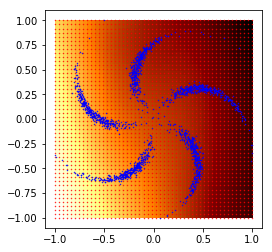

....................2000 -0.293728
pos [-0.41795057 -0.41010833 -0.4896071  -0.29761726 -0.39952016] -0.340093
neg [ 0.55674905  0.5564028   0.54696035  0.53097093  0.51441967] 0.332799


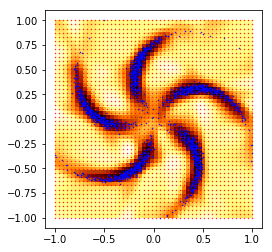

....................4000 -0.308482
pos [-0.42832223 -0.40729171 -0.51052201 -0.32473284 -0.38327324] -0.350947
neg [ 0.4795121   0.4863081   0.49149549  0.49653089  0.50313389] 0.35068


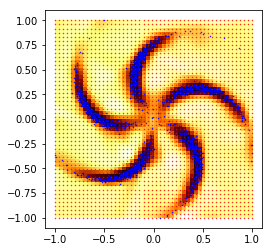

.........4999 -0.310838
pos [-0.4231438  -0.39148003 -0.50087261 -0.31821597 -0.3738296 ] -0.344329
neg [ 0.46853352  0.4751693   0.48430121  0.49595976  0.50985813] 0.358576


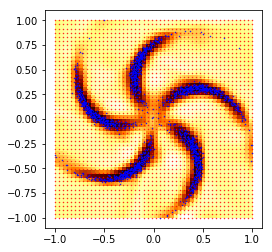

Energy


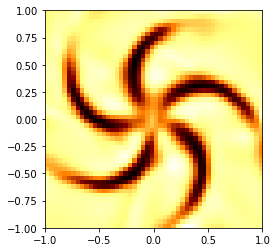

Samples


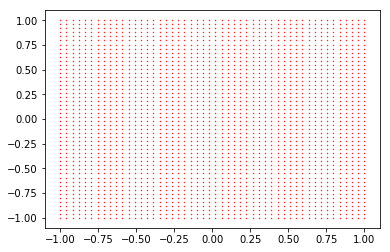

In [718]:
# Fix energy, then 
tf.reset_default_graph()
sess = tf.Session()

negs = get_dense_grid(X) #np.random.randn(512, 2)*0.4
with sess.as_default():
    energy = Energy(2)
    sess.run(tf.global_variables_initializer())

    MAX_ITR=5000
    extra_data_base, _ =pinwheel_data(MAX_ITR*2, num_classes=5, norm_data=norm_data)
    extra_data = extra_data_base+ np.random.randn(extra_data_base.shape[0],2)*0.05
    for itr in range(MAX_ITR):
        
        #particles = np.concatenate([extra_data[:itr*2]], axis=0)
        if itr<10000:
            particles = negs
        else:
            particles = 2#extra_data_base + np.random.randn(extra_data_base.shape[0],2)*0.2*(1-(itr/MAX_ITR))
        
        loss = energy.update(X, particles)
        
        if itr % 100 == 0:
            print('.', end='')
        if itr % 2000 == 0 or itr==(MAX_ITR-1):
            print(itr, loss)
            print('pos', energy.eval(X[:5]), np.mean(energy.eval(X)))
            print('neg', energy.eval(particles[:5]), np.mean(energy.eval(particles)))

            plot_gridpoints(energy.eval(get_dense_grid(X)))
            plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
            plt.scatter(X[:,0], X[:,1], color='b', s=0.2)

            plt.show()
          
    print('Energy')
    plot_gridpoints(energy.eval(get_dense_grid(X)))
    plt.show()
    print('Samples')
    plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
    plt.show()
GEN_COUNTER=0

.0 0.00225091
neg [ 0.40100741 -0.44660959  0.44514221  0.51614106  0.4840008 ] 0.397727


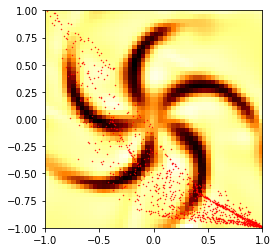

..........1000 -0.129412
neg [ 0.42679274  0.42679274  0.42679274  0.42683274  0.58502334] 0.45264


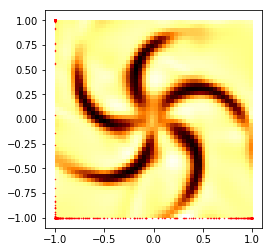

..

KeyboardInterrupt: 

In [748]:
GEN_COUNTER+=1
with sess.as_default():
    svgd = SVGDGenerator(2,2,energy, name='gen%d'%GEN_COUNTER, use_tf=True)
    sess.run(tf.variables_initializer(svgd.vars))

    MAX_ITR=5000
    for itr in range(MAX_ITR):
        
        loss = svgd.update(N=512, lr=5e-3, clip=100., verbose=False)
        
        if itr % 100 == 0:
            print('.', end='')
        if itr % 1000 == 0 or itr==(MAX_ITR-1):
            particles = svgd.generate(N=1024)
            print(itr, loss)
            #print('pos', energy.eval(X[:5]), np.mean(energy.eval(X)))
            print('neg', energy.eval(particles[:5]), np.mean(energy.eval(particles)))

            plot_gridpoints(energy.eval(get_dense_grid(X)))
            plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
            #plt.scatter(X[:,0], X[:,1], color='b', s=0.2)

            plt.show()
        
    print('Samples')
    plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
    plt.show()

.0 0.045316
pos [ 0.45784429  0.47833496  0.48382002  0.20462508  0.63313955] 0.497078
neg [ 0.58937132  0.53634143  0.58556986  0.52188265  0.16302967] 0.501363


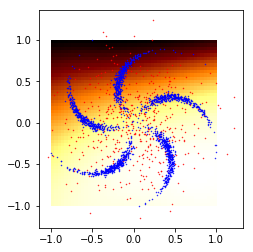

....................2000 -0.245116
pos [-22.01229858 -22.42280769 -21.25087166 -23.56766129 -19.06086731] -21.1038
neg [-19.84876633 -20.2992363  -19.78271484 -20.09492493 -22.35956573] -20.6616


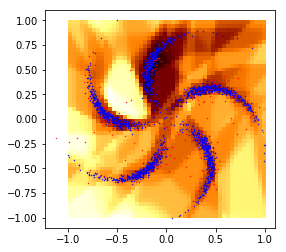

....................4000 -0.695806
pos [-10.7591362  -10.76809406  -1.32131529  -3.17258716  -5.82712555] -4.3409
neg [-10.75971222  -3.58585501  -3.26503944  -5.98483706  -4.14179516] -3.40626


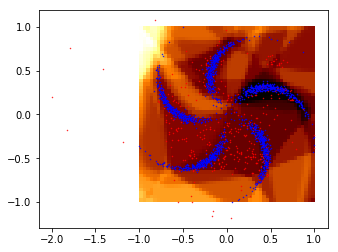

....................6000 -1.17569
pos [ 4.09161568  0.462672   -8.14164066  3.52367187 -7.09468174] -4.37575
neg [-0.99048853 -3.48998356 -7.56729031 -5.8197546   5.24847841] -2.94671


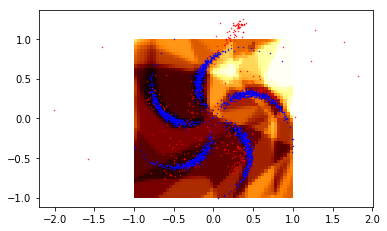

....................8000 2.47787
pos [ 3.5147891   3.51478148 -9.50205898 -8.37576485 -1.45346427] -5.46169
neg [ -8.37611103 -12.86357212  -8.37609005   3.51481009 -12.85969353] -7.68886


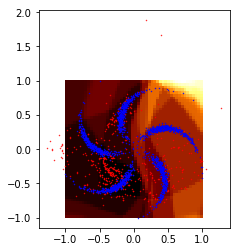

....................10000 -0.159523
pos [-7.77043867 -7.76804686  0.04205537 -7.26673031 -3.46915221] -2.27234
neg [ 0.22525454  3.620574   -3.48465681 -7.49890614  0.09475684] -1.74815


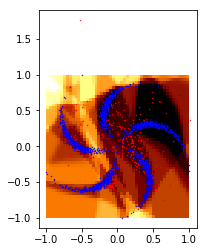

....................12000 -0.177775
pos [ 4.87576962  4.87536335  2.10794878  4.80768013 -1.80671978] 2.08069
neg [-1.81560946  5.09650373  1.35355854  7.43288326  1.24811172] 2.49198


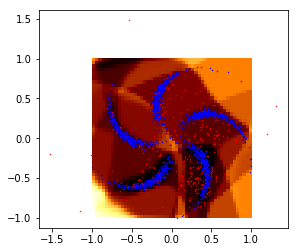

....................14000 -0.0789763
pos [ 10.53870583  10.53353214  27.57286644  17.41076279  15.74224663] 19.3936
neg [ 23.96673584  10.59257889  10.53334332  10.53335667  27.6004982 ] 19.7515


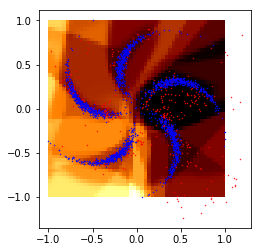

....................16000 1.01712
pos [ 21.74350357  21.74350357  21.74630356  21.74350166  17.53921509] 19.4848
neg [ 21.74349213  17.53921509  21.74350357  21.74350357  21.74350166] 18.6576


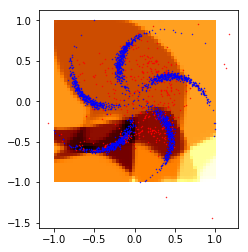

....................18000 0.361064
pos [ 26.22106743  28.07483482  25.43051529  27.46403122  26.20939255] 26.0984
neg [ 25.40494537  26.19691658  25.40494537  25.41074944  25.40494537] 26.0238


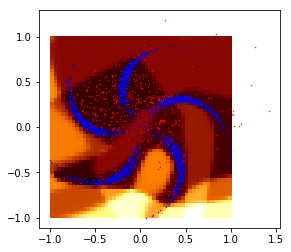

...................19999 -1.74913
pos [ 33.07965469  32.77799225  35.90164566  34.69413376  21.38165474] 31.3504
neg [ 34.7168541   22.76907539  32.93991852  32.7770195   33.72385406] 33.4034


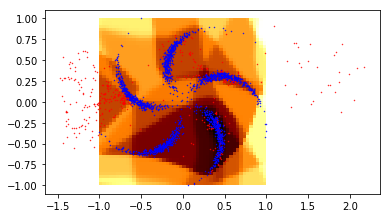

Energy


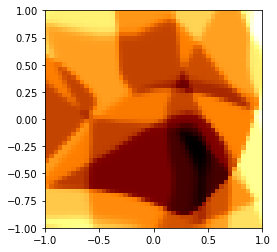

Samples


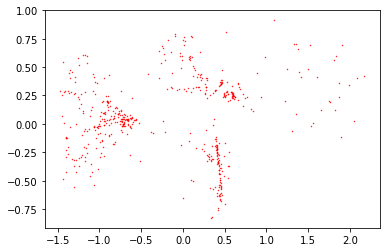

In [755]:
# Only SVGD
tf.reset_default_graph()
sess = tf.Session()

particles = np.random.randn(512, 2)*0.4
with sess.as_default():
    energy = Energy(2, magnitude_penalty_wt=0.0)
    svgd = SVGDGenerator(2,2,energy, name='gen21', use_tf=False)

    sess.run(tf.global_variables_initializer())

    MAX_ITR=20000
    for itr in range(MAX_ITR):


        loss = energy.update(X, particles)
        particles = svgd.svgd(particles, itrs=2, alpha=1e-2, h=-1.0, clip=100)

        
        if itr % 100 == 0:
            print('.', end='')
        if itr % 2000 == 0 or itr==(MAX_ITR-1):
            print(itr, loss)
            print('pos', energy.eval(X[:5]), np.mean(energy.eval(X)))
            print('neg', energy.eval(particles[:5]), np.mean(energy.eval(particles)))

            plot_gridpoints(energy.eval(get_dense_grid(X)))
            plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
            plt.scatter(X[:,0], X[:,1], color='b', s=0.2)

            plt.show()
          
    print('Energy')
    plot_gridpoints(energy.eval(get_dense_grid(X)))
    plt.show()
    print('Samples')
    plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
    plt.show()


.0 1.17748
pos [-0.65894991 -0.65499121 -0.542216   -0.59715056 -0.59855032] -0.584019
neg [-0.5642035  -0.56166339 -0.52919519 -0.55290425 -0.49150065] -0.514647


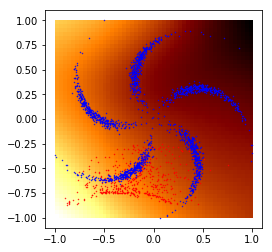

..........1000 -0.0575908
pos [-0.0857476  -0.14863139 -0.15011907 -0.09943938 -0.13528001] -0.0753036
neg [ 0.17051727  0.32272959  0.08903849  0.30230901 -0.13076705] 0.0915325


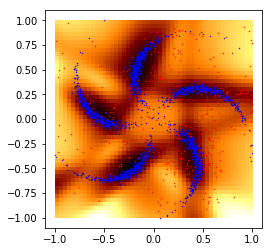

..........2000 -0.0924717
pos [-0.19204772 -0.25304931 -0.36396843 -0.10334733 -0.30012894] -0.137872
neg [ 0.47413397  0.37181208  0.15994555  0.35607538  0.54557544] 0.130235


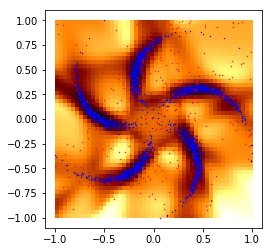

..........3000 -0.0826242
pos [-0.15289992 -0.14874297 -0.31461632 -0.14427716 -0.13333786] -0.118934
neg [ 0.38785279 -0.15091085 -0.02161968  0.14830934 -0.1781323 ] 0.118821


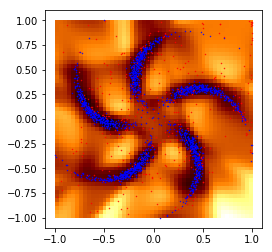

..........4000 -0.0807529
pos [-0.09422147 -0.1328094  -0.36050957 -0.13133875 -0.07632792] -0.11825
neg [ 0.19027054 -0.11111026 -0.28284186  0.60064417 -0.18843764] 0.1277


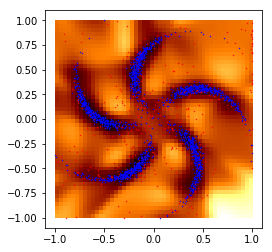

..........5000 -0.0962042
pos [-0.16859317 -0.14978528 -0.33843327 -0.15141514 -0.10036004] -0.116668
neg [-0.03901315  0.47763735  0.44624519 -0.17413628  0.38360226] 0.134351


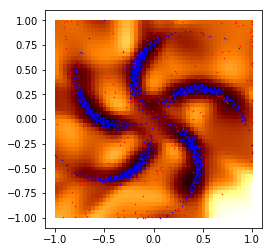

..........6000 -0.0616168
pos [-0.15718991 -0.17125845 -0.30941236  0.00568946 -0.09565985] -0.113786
neg [-0.24062213  0.5059458  -0.16320926  0.54633319  0.66071516] 0.0929091


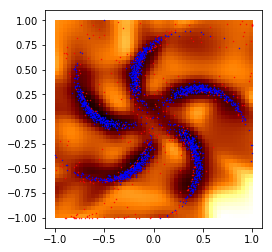

..........7000 -0.081643
pos [-0.17734581 -0.08991325 -0.29787219 -0.09236669 -0.10929418] -0.118661
neg [-0.1846441   0.59885991 -0.10415435  0.41213009 -0.18736959] 0.115848


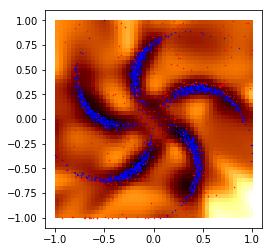

..........8000 -0.115899
pos [-0.19690317 -0.17125988 -0.22039759 -0.0988602  -0.06205356] -0.14651
neg [-0.05103505  0.25711447  0.47520372  0.50044179 -0.22314829] 0.144411


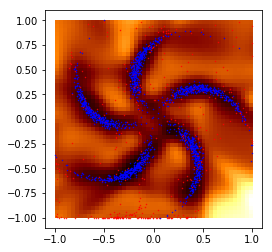

..........9000 -0.12653
pos [-0.13006115 -0.09289575 -0.28470796 -0.25904176 -0.14106607] -0.164101
neg [-0.12357068 -0.08726954  0.58166713  0.3552286  -0.09785372] 0.173812


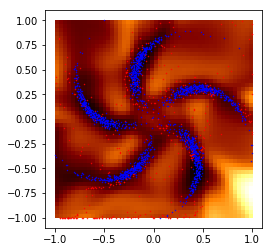

..........10000 -0.114204
pos [-0.20087379 -0.23932922 -0.28462809 -0.09868297 -0.27527285] -0.180098
neg [-0.26222867  0.24124563 -0.25907028  0.17629802 -0.30561429] 0.118193


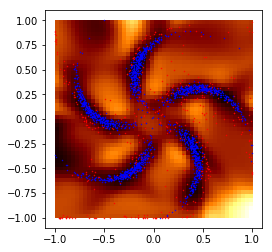

..........11000 -0.116498
pos [-0.18612516 -0.137604   -0.14440823 -0.07666916 -0.18723297] -0.12254
neg [-0.10365051  0.08021504 -0.06723487 -0.16902244  0.41922385] 0.169222


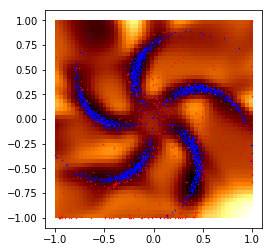

..........12000 -0.137091
pos [-0.28069276 -0.23361409 -0.12342882 -0.32969311 -0.10660243] -0.171079
neg [-0.10262585  0.09578013 -0.23256266  0.55813122  0.47372973] 0.176255


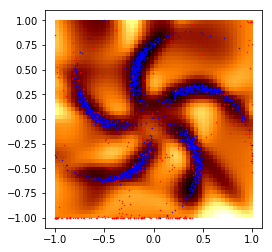

..........13000 -0.131546
pos [-0.16498744 -0.18285    -0.14076293 -0.1428414  -0.30965161] -0.15244
neg [ 0.13013661 -0.18913472  0.45349467 -0.09232199 -0.05515301] 0.176873


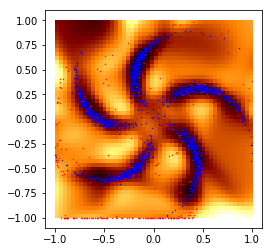

..........14000 -0.137932
pos [-0.12613124 -0.1108892  -0.14458108 -0.15201965 -0.28819501] -0.149835
neg [ 0.00376728  0.20340824  0.16785836 -0.24809039  0.1776278 ] 0.173882


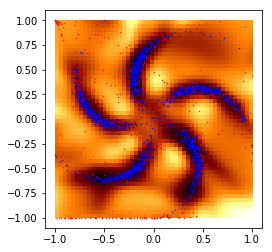

..........15000 -0.116618
pos [-0.16345644 -0.0849303  -0.21965384 -0.14968234 -0.27948093] -0.14707
neg [-0.04023373 -0.20964813  0.36127502  0.02450061 -0.0343675 ] 0.148747


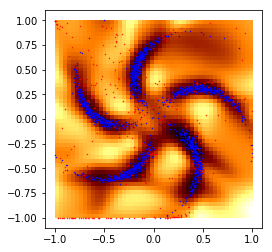

..........16000 -0.124335
pos [-0.06194687 -0.13713253 -0.14976788 -0.12182584 -0.25554442] -0.178993
neg [ 0.45711902 -0.12598526  0.04643941  0.33642298 -0.20206523] 0.135564


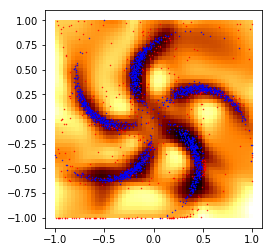

..........17000 -0.110586
pos [-0.05158484 -0.08848906 -0.17383659 -0.09905198 -0.10097277] -0.131471
neg [ 0.1123755   0.37694395  0.40053314  0.15091789  0.46493784] 0.147175


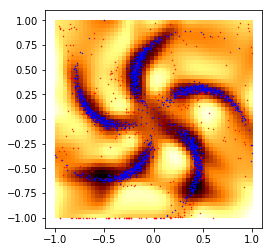

..........18000 -0.131081
pos [-0.08884156 -0.03051186 -0.29844332 -0.04567243 -0.25102282] -0.1656
neg [ 0.21858048  0.47362703 -0.11563289  0.45857227  0.51225245] 0.162046


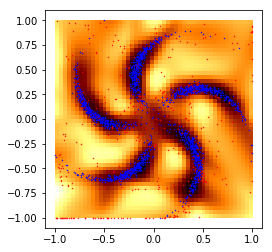

..........19000 -0.103387
pos [-0.11196673 -0.09720027 -0.19746459 -0.09892273 -0.21706223] -0.131278
neg [ 0.45553249  0.44950521  0.4585979  -0.05407476  0.49744511] 0.129896


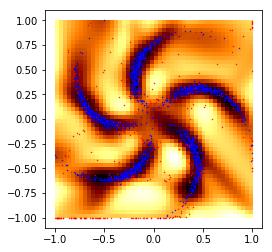

.........19999 -0.0936584
pos [-0.11193514 -0.05392218 -0.26361477  0.12950483 -0.27347732] -0.134832
neg [ 0.14087009  0.44078553  0.47142929 -0.41466248 -0.05768752] 0.134115


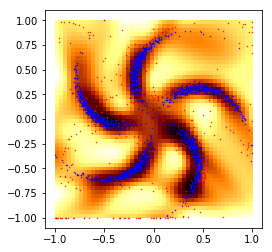

Energy


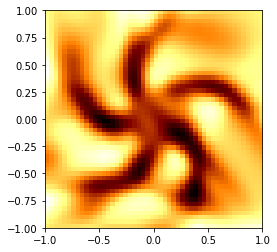

Samples


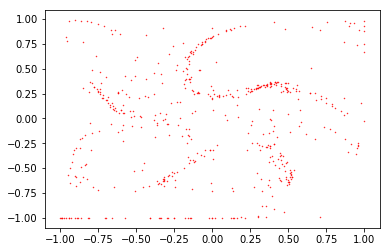

In [749]:
# stein gan
tf.reset_default_graph()
sess = tf.Session()

particles = np.random.randn(64, 2)
with sess.as_default():
    energy = Energy(2)
    svgd = SVGDGenerator(2,2,energy, name='gen', use_tf=True)

    sess.run(tf.global_variables_initializer())

    MAX_ITR=20000
    for itr in range(MAX_ITR):


        for _ in range(2):
            gen_loss = svgd.update(N=256, lr=1e-3, h=-1.0, clip=100)
        particles = svgd.generate(N=512)
        
        for _ in range(1):
            loss = energy.update(X, particles)

        
        if itr % 100 == 0:
            print('.', end='')
        if itr % 1000 == 0 or itr==(MAX_ITR-1):
            print(itr, loss)
            print('pos', energy.eval(X[:5]), np.mean(energy.eval(X)))
            print('neg', energy.eval(particles[:5]), np.mean(energy.eval(particles)))

            plot_gridpoints(energy.eval(get_dense_grid(X)))
            plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
            plt.scatter(X[:,0], X[:,1], color='b', s=0.2)

            plt.show()
          
    print('Energy')
    plot_gridpoints(energy.eval(get_dense_grid(X)))
    plt.show()
    print('Samples')
    plt.scatter(particles[:,0], particles[:,1], color='r', s=0.2)
    plt.show()


